# Homework 3: SVM Model

C111156103, 潘奕濬

## 環境設定

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Import data from UCI machine learning repository

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

## 缺失值處理 - missing values

In [4]:
# Check missing values
missing_values = X.isnull().sum()
print("特徵缺失值：")
print(missing_values)

missing_values_y = y.isnull().sum()
print("\n目標變數缺失值：")
print(missing_values_y)

特徵缺失值：
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

目標變數缺失值：
poisonous    0
dtype: int64


很明顯 stalk-root 有一個缺失值。查看缺失值相對於所有值的比例。

In [5]:
missing_ratio = X.isnull().sum().sum() / X.shape[0]
print(f"缺失值比例：{missing_ratio:.2%}")

缺失值比例：30.53%


居然有 30%！要不就刪除這一個 column 好了 …

In [6]:
# drop 'stalk-root' column and meaningless column
Xc = X.drop(columns=['stalk-root', 'veil-type'])

## Label 分類數值

### 各特徵的唯一值數量及其項目

In [7]:
# 各特徵的唯一值數量及其項目
for _col in Xc.columns:
    print(f"\n{_col}: {Xc[_col].nunique()} 個唯一值")
    print(Xc[_col].value_counts())

# 建立一個包含每個特徵的唯一值數量和項目的DataFrame
features_info = []
for _col in Xc.columns:
    _unique_values = Xc[_col].unique().tolist()
    features_info.append({
        'feature': _col,
        'unique_count': Xc[_col].nunique(),
        'values': _unique_values
    })

features_info_df = pd.DataFrame(features_info)
features_info_df


cap-shape: 6 個唯一值
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64

cap-surface: 4 個唯一值
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64

cap-color: 10 個唯一值
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64

bruises: 2 個唯一值
bruises
f    4748
t    3376
Name: count, dtype: int64

odor: 9 個唯一值
odor
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

gill-attachment: 2 個唯一值
gill-attachment
f    7914
a     210
Name: count, dtype: int64

gill-spacing: 2 個唯一值
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

gill-size: 2 個唯一值
gill-size
b    5612
n    2512
Name: count, dtype: int64

gill-color: 12 個唯一值
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64

st

,feature,unique_count,values
0,cap-shape,6,"[x, b, s, f, k, c]"
1,cap-surface,4,"[s, y, f, g]"
2,cap-color,10,"[n, y, w, g, e, p, b, u, c, r]"
3,bruises,2,"[t, f]"
4,odor,9,"[p, a, l, n, f, c, y, s, m]"
5,gill-attachment,2,"[f, a]"
6,gill-spacing,2,"[c, w]"
7,gill-size,2,"[n, b]"
8,gill-color,12,"[k, n, g, p, w, h, u, e, b, r, y, o]"
9,stalk-shape,2,"[e, t]"


### 針對 Binary 資料使用 label encoder

In [8]:
Xc_encoded_part1 = Xc.copy()

binary_features = features_info_df[features_info_df["unique_count"] <= 2]

le = LabelEncoder()
for col in binary_features["feature"]:
    Xc_encoded_part1[col] = le.fit_transform(Xc_encoded_part1[col])

### 針對 Non-binary 資料使用 one-hot encoder

In [9]:
onehot_features = features_info_df[features_info_df["unique_count"] > 2]

Xc_encoded = pd.get_dummies(Xc_encoded_part1, columns=onehot_features["feature"], dtype='int64')
Xc_encoded

,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8121,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,1,0,1,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


## 針對目標變數進行 label encoding

In [10]:
# encode y to int
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

y_encoded

array([1, 0, 0, ..., 0, 1, 0], shape=(8124,))

## 降維資料

老師只需要 2 個特徵，且我們已知 Y 分類。使用 PCA 無監督演算法取出 2 個特徵。

In [11]:
# use PCA to reduce dimension
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.set_output(transform="pandas")
Xce_n2 = pca.fit_transform(Xc_encoded)
Xce_n2


,pca0,pca1
0,1.262835,0.290677
1,1.279710,-0.408508
2,1.462530,-0.166226
3,1.294616,-0.058005
4,0.948154,0.349892
...,...,...
8119,0.601465,0.169926
8120,0.519914,0.185018
8121,0.712597,0.002842
8122,-0.938937,1.938357


## 切割資料集與訓練集

In [12]:
Xce_n2_train, Xce_n2_test, y_encoded_train, y_encoded_test = train_test_split(Xce_n2, y_encoded, test_size=0.2, random_state=42, stratify=y)

## 使用核技巧在高維空間中尋找分離超平面

In [13]:
svm = SVC(kernel='rbf', random_state=42, gamma="auto", C=10.0)
svm.fit(Xce_n2_train, y_encoded_train)

y_pred = svm.predict(Xce_n2_test)

In [14]:
svm

SVC(C=10.0, gamma='auto', random_state=42)

### Accuracy

In [15]:
print("Accuracy: ", accuracy_score(y_encoded_test, y_pred))

Accuracy:  0.8996923076923077


### 決策圖

/Volumes/Dev/nkust/nkust-homework/semester-6/machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


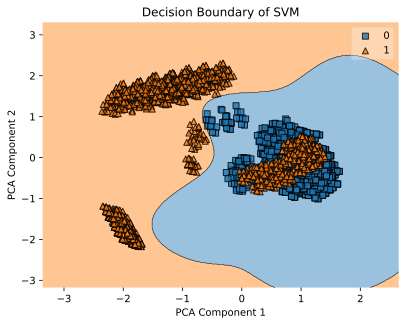

In [16]:
from mlxtend.plotting import plot_decision_regions

# SAFETY: X does not have valid feature names, but LogisticRegression was fitted with feature names
# plot_decision_regions only accepts the Numpy array as input: https://github.com/rasbt/mlxtend/issues/335
plot_decision_regions(Xce_n2_train.to_numpy(), y_encoded_train, clf=svm)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary of SVM')
plt.show()
